<a href="https://colab.research.google.com/github/Ostrich2002/SRiSHTi23/blob/main/SRISHTI'23_assignment11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Convolutional Neural Networks**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing some pytorch packages
import torch
from torch.nn import Conv2d

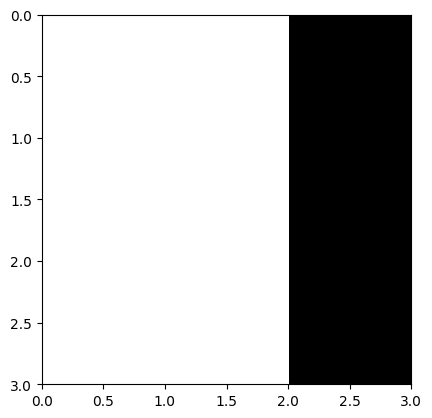

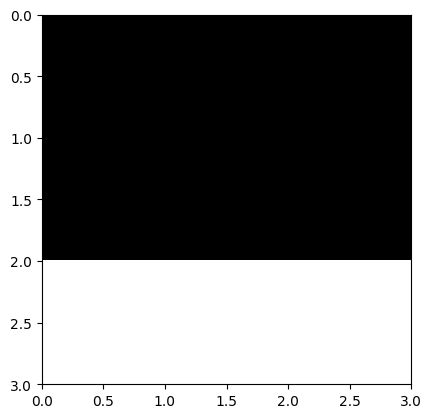

In [3]:
# 2D 3x3 binary image with vertical edge
image1 = np.array([[1,1,0], [1,1,0], [1,1,0]])

# 2D 3x3 binary image with horizontal edge
image2 = np.array([[0,0,0], [0,0,0], [1,1,1]])

# On plotting the images
plt.imshow(image1, cmap='gray', extent=[0, 3, 3, 0])
plt.show()
plt.imshow(image2, cmap='gray', extent=[0, 3, 3, 0])
plt.show()

In [4]:
# Vertical Line filter
filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

# Applying filter to first image
output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

# Applying filter to second image
output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  3
Output from second image:  0


In [5]:
# Horizontal edge filter
filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

output = np.sum(np.multiply(image1, filter))
print('Output from first image: ', output)

output = np.sum(np.multiply(image2, filter))
print('Output from second image: ', output)

Output from first image:  0
Output from second image:  3


In [6]:
def apply_conv(image, kernel, padding=0, stride=1):

  #--------IMAGE PREPROCESSING-------
  image = torch.from_numpy(image)
  # Pytorch requires input to convolution in (N,C,H,W), where N = batch size and C=#channels in input
  input = image.view((1,1,image.shape[0], image.shape[1]))

  # --------------KERNEL-------------
  kernel = torch.from_numpy(kernel.astype(np.float32))

  # Pytorch requires kernel of shape (N,C,H,W), where N = batch size and C=#channels in input
  kernel = kernel.view((1,1,kernel.shape[0], kernel.shape[1]))

  # ---------CONVOLUTION LAYER from Pytorch--------
  conv = Conv2d(in_channels=1, out_channels=1, kernel_size=kernel.shape, padding=padding, stride=stride)

  # Set the kernel weights in the convolution layer
  conv.weight = torch.nn.Parameter(kernel)

  # ---------APPLY CONVOLUTION--------
  output = conv(input.float())
  output_img = output.data.numpy()  # Tensor to back in numpy
  output_img = output_img.reshape((-1, output_img.shape[-1])) # Reshape to 2D image

  return output_img

In [10]:
# Our original lotus image
image = cv2.imread('/content/Image_for_tut-11.jpeg', 0)

filter = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

out1 = apply_conv(image, filter, padding=0, stride=1)

filter = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

out2 = apply_conv(image, filter, padding=0, stride=1)

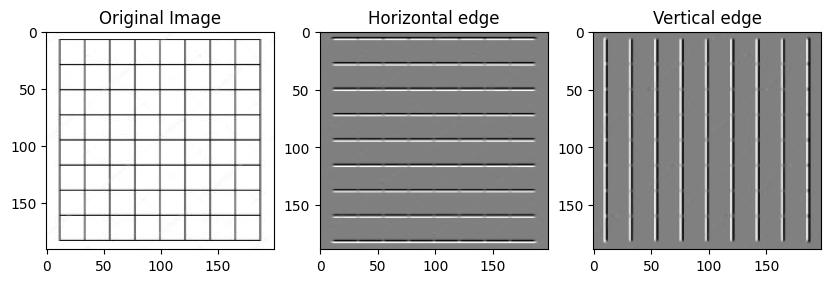

In [11]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,3,1)
ax.imshow(image, cmap='gray')
ax.set_title('Original Image')
ax = fig.add_subplot(1,3,2)
ax.set_title('Horizontal edge')
ax.imshow(out1, cmap='gray')
ax = fig.add_subplot(1,3,3)
ax.imshow(out2, cmap='gray')
ax.set_title('Vertical edge')
plt.show()

**Learning to train a CNN network**

In [12]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [13]:
#  Images returned from torchvision dataset classes is in range [0,1]
# We transform them to tensors and normalize them to range [-1,1] using 'Normalize' transform

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 73165063.12it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [14]:
print('Training data shape : ', trainset.data.shape, len(trainset.targets))
print('Testing data shape : ', testset.data.shape, len(testset.targets))

# Find the unique numbers from the train labels
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  (50000, 32, 32, 3) 50000
Testing data shape :  (10000, 32, 32, 3) 10000
Total number of outputs :  10
Output classes :  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [15]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [16]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))

In [17]:
# CNN with 2 CONV layers and 3 FC layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 128)
        # output layer 10 classes
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [19]:
# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

In [20]:
# SGD optimizer with momentum
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

In [22]:
num_epochs = 5  # iterations
train_losses, train_acc = train(num_epochs, model, trainloader, criterion, optimizer)

Epoch 1/5, Loss: 0.0099, Accuracy: 54.8300
Epoch 2/5, Loss: 0.0082, Accuracy: 62.7680
Epoch 3/5, Loss: 0.0072, Accuracy: 67.8940
Epoch 4/5, Loss: 0.0063, Accuracy: 72.0320
Epoch 5/5, Loss: 0.0055, Accuracy: 75.3540


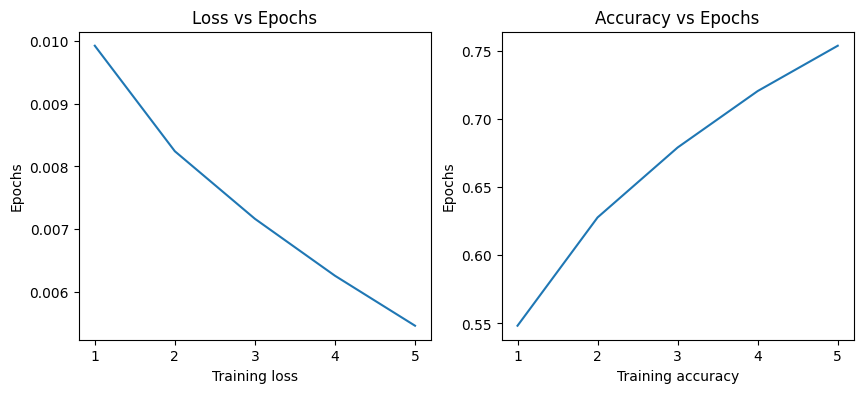

In [23]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
plt.xlabel('Training accuracy')
plt.ylabel('Epochs')
ax.set_title('Accuracy vs Epochs')
plt.show()

In [24]:
# Accuracy on test data after training
test_model(model, testloader)

Accuracy of the network: 65 %


Question 1

Answer :

There are several reasons why Convolutional Neural Networks (CNNs) are preferred over Artificial Neural Networks (ANNs) for image classification tasks:

> Spatial Hierarchies and Local Connectivity: CNNs are specifically designed to capture spatial hierarchies and exploit the local connectivity present in images. Convolutional layers in CNNs use shared weights and local receptive fields, allowing them to effectively capture patterns and features in different spatial locations of an image. ANNs, on the other hand, treat the input as a flat vector and do not consider the spatial relationships between pixels.

> Translation Invariance: CNNs are inherently translation invariant, meaning they can recognize patterns and features regardless of their location in an image. This property is particularly beneficial for image classification tasks where the location of objects can vary. ANNs, being fully connected, are sensitive to the precise location of features, making them less suitable for tasks requiring translation invariance.

> Parameter Efficiency: CNNs typically have fewer parameters compared to ANNs, which reduces the risk of overfitting and allows them to be trained more efficiently. The weight sharing in CNNs helps capture similar patterns across different spatial locations, resulting in a more compact representation.

> Feature Hierarchies: CNNs learn multiple layers of hierarchical representations from the input data, starting with low-level features such as edges and gradually progressing to higher-level features. This enables them to learn increasingly complex and abstract representations of the input images. ANNs, being fully connected, do not possess this innate ability to learn hierarchical features.

> Performance: CNNs have shown superior performance in image classification tasks compared to ANNs. They have achieved state-of-the-art results in various benchmark datasets and competitions, demonstrating their effectiveness in handling visual data.

Overall, CNNs are specifically tailored for image-related tasks, taking advantage of their spatial hierarchies, local connectivity, translation invariance, and parameter efficiency. These characteristics make CNNs a preferred choice for image classification tasks over ANNs.

**Question 3**

Answer :

If you reduce the number of convolutional layers in a Convolutional Neural Network (CNN) to only 1, it would significantly impact the network's ability to learn complex features and patterns from the input data. Here's what happens when you have only one convolutional layer:

> Limited Feature Extraction: Convolutional layers in a CNN are responsible for extracting different features and patterns from the input data. By having multiple convolutional layers, the network can learn a hierarchy of features, starting from low-level features (e.g., edges, corners) in the initial layers to higher-level features (e.g., shapes, textures) in the subsequent layers. With only one convolutional layer, the network's ability to extract complex features is limited, potentially resulting in reduced performance.

> Reduced Model Capacity: Each convolutional layer consists of multiple filters, and each filter learns to detect specific patterns in the input data. By having multiple convolutional layers, the network can learn a larger variety of filters, enabling it to capture more diverse and detailed information from the input. With just one convolutional layer, the model's capacity to capture a wide range of patterns and features is significantly reduced, limiting its representation power.

> Limited Abstraction and Generalization: Deep CNN architectures are designed to progressively learn more abstract and high-level representations of the input data. Each additional convolutional layer allows the network to build upon the previously learned features and capture more abstract representations. By reducing the number of convolutional layers to one, the network's ability to learn hierarchical representations is constrained, potentially hindering its capacity to generalize well to new, unseen data.

> Potential Overfitting: Having only one convolutional layer in a CNN increases the risk of overfitting, where the network may memorize the training data instead of learning meaningful representations. A deeper network with multiple convolutional layers helps in regularizing the model and reducing overfitting by learning more generalizable features.

**Question 4 : **

Answer :

The Softmax activation function is commonly used in the last layer of a Convolutional Neural Network (CNN) for multi-class classification tasks. However, there are scenarios where the Softmax activation may not be used in the last layer of a CNN, and here are a few possible reasons:

> Binary Classification: If the classification problem is binary, meaning there are only two classes to predict, using the Softmax activation is unnecessary. In this case, a single neuron with a sigmoid activation function can be used in the output layer to provide a probability-like output for the positive class.

> Multi-label Classification: When dealing with multi-label classification, where each input can have multiple class labels assigned to it, the Softmax activation may not be appropriate. Instead, a sigmoid activation is commonly used in the last layer, with each neuron representing the probability of an individual class label being present.

> Regression Tasks: If the problem is a regression task rather than a classification task, the Softmax activation is not suitable. Regression tasks involve predicting continuous numerical values, so the last layer of the CNN typically uses a linear activation function or no activation function at all.

> Pre-trained Models: In some cases, the last layer of a pre-trained CNN model may not include the Softmax activation. Pre-trained models are trained on large-scale datasets for various tasks, including image classification, and their last layer might output unnormalized scores or logits. The Softmax activation can be applied separately during the inference or fine-tuning process to obtain the probabilities for each class.

**Using learnt representations**

In [25]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import time
import os

In [26]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2023-07-12 11:03:28--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.52.128, 13.226.52.90, 13.226.52.36, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.52.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  79.9MB/s    in 0.6s    

2023-07-12 11:03:29 (79.9 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [28]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes

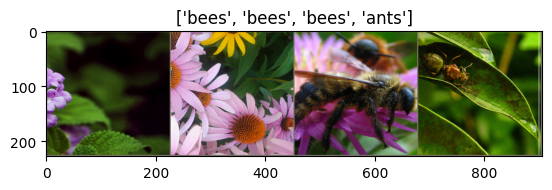

In [29]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [30]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [31]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [32]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


In [33]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6330 Acc: 0.7090

Epoch 1/4
----------
Loss: 0.5146 Acc: 0.7828

Epoch 2/4
----------
Loss: 0.3840 Acc: 0.8320

Epoch 3/4
----------
Loss: 0.5215 Acc: 0.7746

Epoch 4/4
----------
Loss: 0.7507 Acc: 0.7582



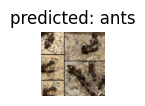

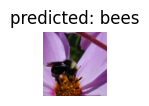

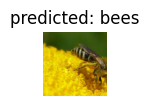

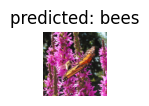

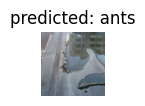

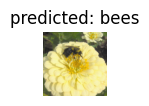

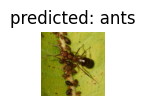

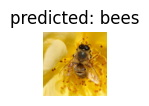

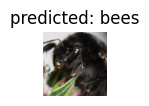

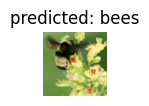

In [34]:
visualize_model(model_ft)

Question 1

Answer :

> Increased Training Data: Data augmentation helps increase the effective size of the training dataset. By applying various transformations to the original data, you generate additional samples that provide more diversity and variation. This helps the model generalize better and reduces the risk of overfitting, especially when the original dataset is limited.

> Improved Model Robustness: By introducing variations in the training data, data augmentation makes the model more robust to changes in the input data during inference. It exposes the model to a wider range of possible inputs, including different scales, orientations, positions, and deformations. As a result, the model learns to be more invariant to such variations and performs better when faced with real-world data that may differ from the original training set.

> Regularization and Generalization: Data augmentation acts as a form of regularization, helping to prevent overfitting by adding noise and introducing small perturbations to the training data. Regularization techniques improve the model's ability to generalize well to unseen data by discouraging it from relying too heavily on specific patterns or features present in the training set.

> Improved Feature Extraction: Certain data augmentation techniques, such as random crops or rotations, can help the model learn better feature representations. By presenting different views of the same object, the model can capture various aspects and viewpoints of the object, leading to more robust and discriminative features.

> Domain Adaptation: Data augmentation techniques can be useful for domain adaptation tasks. By simulating variations that are specific to the target domain, data augmentation helps the model adapt and generalize to the target domain by learning domain-invariant features.

> Class Imbalance Mitigation: Data augmentation can address class imbalance issues by artificially increasing the representation of underrepresented classes. For example, if a particular class has fewer samples, you can use techniques like image flipping, rotation, or scaling to create additional samples for that class, balancing the class distribution.

Question 2

Answer :

If you don't use a pre-trained ResNet model and train the model from scratch on the "ants vs bees" dataset, the performance may be significantly different compared to using a pre-trained model. Here are a few factors to consider:

1. **Training from Scratch**: When you set `pretrained=False` and train the model from scratch, the model starts with randomly initialized weights. This means that the model has no prior knowledge or pre-learned features from a large-scale dataset. As a result, the initial performance may be relatively lower, and the model will need to learn all the necessary features and representations solely based on the "ants vs bees" dataset.

2. **Training Time and Data Requirements**: Training a deep neural network from scratch can be computationally expensive and time-consuming, especially if the model is deep and the dataset is large. It requires a significant amount of labeled data to capture meaningful patterns and generalize well. If the "ants vs bees" dataset is small, training from scratch might lead to overfitting, where the model memorizes the training examples instead of learning generalizable features.

3. **Complexity of the Task**: The complexity of the classification task in the "ants vs bees" dataset can also influence the model's performance when trained from scratch. If the task is relatively simple, such as distinguishing between ants and bees based on basic visual features, training from scratch might still yield reasonable performance. However, if the task involves more intricate or fine-grained distinctions, such as identifying specific species or subtle differences, training from scratch might be more challenging without the benefits of pre-trained features.

4. **Overfitting**: When training from scratch, there is a higher risk of overfitting, especially when the model has a large number of parameters and the dataset is limited. Overfitting occurs when the model becomes too specialized to the training data and performs poorly on unseen examples. To mitigate overfitting, techniques such as regularization, data augmentation, and early stopping need to be applied.

In summary, training a ResNet model from scratch on the "ants vs bees" dataset without using pre-trained weights can result in lower initial performance and may require a larger dataset and longer training time to achieve competitive results. The complexity of the task, overfitting risks, and available computational resources are important factors to consider when deciding whether to train from scratch or use pre-trained models.

Question 3

Answer :

If a ResNet model was pre-trained on a dataset that is significantly different from the "ants vs bees" dataset, the performance of using this pre-trained model may vary. Here are a few factors to consider:

1. **Transfer Learning**: Transfer learning allows us to leverage pre-trained models trained on large-scale datasets, even if they are different from the target dataset. The early layers of a deep neural network tend to learn general and low-level features that are applicable to various visual tasks. By using a pre-trained model like ResNet, you can benefit from these learned features and their ability to recognize basic shapes, edges, and textures. This can potentially boost the performance of the model on the new dataset.

2. **Domain Shift**: If the pre-trained model's dataset is significantly different from the "ants vs bees" dataset, there may be a domain shift. A domain shift refers to differences in the underlying distribution of the data, such as variations in lighting conditions, backgrounds, object appearances, or object compositions. In such cases, the pre-trained model's learned representations might not directly align with the new dataset. However, lower-level features may still be helpful, while higher-level features may require fine-tuning or adaptation to the new dataset.

3. **Fine-tuning and Adaptation**: To achieve good performance, fine-tuning or adaptation of the pre-trained model is often necessary. Fine-tuning involves retraining the model on the new dataset while keeping the initial pre-trained weights as a starting point. This process allows the model to adapt to the specific characteristics of the "ants vs bees" dataset. By fine-tuning, the model can learn more task-specific features and optimize its performance for the new dataset.

4. **Amount of Available Data**: The size and diversity of the "ants vs bees" dataset also play a role. If the dataset is small, fine-tuning the pre-trained model becomes more challenging as it may lead to overfitting. In such cases, techniques like data augmentation, regularization, and transfer learning from earlier layers may be more critical.

In conclusion, while using a pre-trained ResNet model can provide a good starting point for the "ants vs bees" dataset, the performance might not be optimal due to differences in the data distribution. Fine-tuning and adaptation techniques, along with domain-specific training and adjustments, are usually necessary to achieve the best performance on the target dataset. The availability of sufficient labeled data and domain similarity between the pre-training and target datasets also impact the performance of the pre-trained model.